# NYC SAT Scores: Variability by Demographic


The goal of this project is to explore relationships between SAT scores and demographic factors. The SAT (Scholastic Aptitude Test) is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit so this can be an important test for a kid's future. High average SAT scores are usually indicative of a good school. There's been a lot of debate over the years around the efficacy of standardized tests and the SAT in particular.

New York City has a significant immigrant population and is very diverse, so it is an ideal location for us to analyze. We'll compare demographic factors such as race, income, and gender with SAT scores

We'll be utilizing serveral interrelated datasets in this project:
* NYC SAT Scores: [here](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
* Attendance information for each school: [here](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt)
* Class size information for each school: [here](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
* Advanced Placement exam results for each school: [here](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e)
* Percentage of sudents that graduated and other outcome information: [here](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a)
* Demographic information for each school: [here](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j)
* Surveys of parents, teachers, and students of each school: [here](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8)

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Read in Data

Below we read in our csv files to create pandas dataframes. We then add the dataframes to a dictionary where the name of the dataframe is the key and the dataframe is the value.

In [2]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv(f)
    data[f.replace(".csv", "")] = d

Next we read in the survey data and combine it. We'll filter the survey data to select columns and add the <code>survey</code> dataframe to the dictionary we created above.

In [3]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
#combining the survey data
survey = pd.concat([all_survey, d75_survey], axis=0)

In [4]:
# copy dbn column to new column 
survey["DBN"] = survey.copy()["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
# reduce survey to above columns 
survey = survey.copy()[survey_fields]
# add dataframe to dictionary with other dataframes
data["survey"] = survey

## Add DBN Column

We'll rename the <code>dbn</code> column in <code>hs_directory</code> to <code>DBN</code> so we're staying consistent. The <code>class_size</code> dataframe doesn't have a DBN column so we'll need to add that. If we look at the <code>DBN</code> column in <code>sat_results</code>, we can see that it is a combination of the <code>CSD</code> and <code>SCHOOL NAME</code> columns in <code>class_size</code>. The only difference is, the there is a leading zero in the <code>DBN</code> column.

In [5]:
# renaming column
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

In [6]:
data['class_size'].head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN


In [7]:
data['sat_results'].head(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370


Below we create a function to pad the <code>CSD</code> column with a leading zero. Then we create a <code>DBN</code> column in <code>class_size</code> by combining the padded <code>CSD</code> and <code>SCHOOL CODE</code>.

In [8]:
#function to add leading zeros to CSD 
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
# apply function    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
# create new column
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Data Cleaning

The <code>sat_results</code> dataset has separate columns for the scores of each section (Math, Reading, Writing). We'll combine these into a single column for the total score. 

The <code>hs_directory</code> dataset has a location column (<code>Location 1</code>) which has the longitude and latitude coordinates. We want to extract these coordinates so we can map the schools and idetify any geographic patterns.

In [9]:
# convert columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
# combine section scores into total score
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

In [10]:
# explore values in Location 1 column
data['hs_directory']['Location 1'].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

In [11]:
# create functions to extract lat and lon values for string 
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon
# creating lat and lon columns and converting them to numeric
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### Converting AP Score to Numeric

In [12]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Condensing Data
We will be combining the datasets by the <code>DBN</code> column. If we look at the <code>class_size</code> dataset below, we can see duplicate rows for the same school. This will cause problems when we combine out data because the <code>sat_results</code> dataset may match multiple rows. It looks like the school below has different values in the <code>GRADE</code> and <code>PROGRAM TYPE</code> columns. Since we're only concerned with high school, we'll filter for <code>GRADE</code>: 09-12 and <code>PROGRAM TYPE</code>: GEN ED

In [13]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


In [14]:
# check unique values
data['class_size']['GRADE '].value_counts()

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64

In [15]:
# filter class_size
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size.head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292


We can see that we still have duplicate rows. This is due to the <code>CORE COURSE (MS CORE and 9-12 ONLY)</code> and <code>CORE SUBJECT (MS CORE and 9-12 ONLY)</code> columns. This column only seems to include certain subjects. We want our <code>class_size</code> data to include every single class a school offers, not just a subset of them. What we can do is take the average across all of the classes a school offers. This gives us unique <code>DBN</code> values, while also incorporating as much data as possible into the average.

In [16]:
# average class size for each school
class_size = class_size.groupby("DBN").agg(np.mean)
# reset index
class_size.reset_index(inplace=True)
# add dataframe to dictionary
data["class_size"] = class_size

There are also duplicate rows in <code>demographics</code> and <code>graduation</code>. For <code>demographics</code>, the only column that prevents a given DBN from being unique is <code>schoolyear</code>. We'll filter the rows where schoolyear is 20112012 (most recent). 

For <code>graduation</code>, the <code>Demographic</code> and <code>Cohort</code> columns are what prevent DBN from being unique. A <code>Cohort</code> appears to refer to the year the data represents, and the <code>Demographic</code> appears to refer to a specific demographic group. In this case, we want to pick data from the most recent <code>Cohort</code> available, which is 2006. We also want data from the full cohort, so we'll only pick rows where <code>Demographic</code> is *Total Cohort*.

In [17]:
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [18]:
data["graduation"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


In [19]:
# filter demographics
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
# filter graduation
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Combine the datasets
We'll be using the <code>DBN</code> column to identify matching rows across datasets.There may be <code>DBN</code> values that exist in one dataset but not in another. This is partly because the data is from different years. Each data set also has inconsistencies in terms of how it was gathered. Human error (and other types of errors) may also play a role. 

Since this project is concerned with determining demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from <code>sat_results</code> while minimizing null values. We'll use left join when adding <code>ap_2010</code> and <code>graduation</code> to <code>sat_results</code> and inner join when adding the rest since these datasets have <code>DBN</code> values very close to <code>sat_results</code> and this data is important for our analysis. 

In [20]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

In [21]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


In [22]:
# fill null values with mean of column
combined = combined.fillna(combined.mean())
# fill remaining nulls values with 0
combined = combined.fillna(0)

## Analysis
Now that we've cleaned our data, we can beign our analysis. We'll start off by looking at the correlations between the different columns and <code>sat_score</code> to get an idea of areas we should dig a little deeper.

Besides the scores on sections of the SAT, some of the columns that have the highest positive correlation with SAT scores are <code>white_per</code>, <code>asian_per</code>, <code>AP Test Takers</code>, <code>Total Exams Taken</code>. 
Some of the columns that have the highest negative correlation with SAT scores are <code>frl_percent</code>, <code>ell_percent</code>, <code>hispanic_per</code>, <code>black_per</code>.

In [23]:
correlations = combined.corr()
correlations = correlations["sat_score"]
# positive correlation
print(correlations[correlations > .3].sort_values(ascending=False))

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

In [24]:
# negative correlation
print(correlations[correlations < -.2].sort_values())

frl_percent    -0.722225
sped_percent   -0.448170
ell_percent    -0.398750
hispanic_per   -0.396985
black_per      -0.284139
Name: sat_score, dtype: float64


## SAT Scores and Survey Data
Taking a look at the bar chart below: number of student respondents (<code>N_s</code>) and number of parent respondents (<code>N_p</code>) have the highest correlation with SAT Scores with r values above .4. Initially, this might lead us to believe that schools where students/parents who are more engaged (more likely to fill out the survey) leads to higher SAT Scores. However, the student response rate (<code>rr_s</code>) correlation isn't quite as strong (.23) and the parent response rate (<code>rr_p</code>) is very weak (.05) so it might be more likely that the high correlation with number of student/parent respondents is more indicative of bigger schools with more students has a higher correlation.

We also see moderate correlations with several factors related to safety and respect: Safety and Respect score based on teacher responses (<code>saf_t_11</code>, .31), Safety and Respect score based on student responses (<code>saf_s_11</code>, .34), Safety and Respect total score (<code>saf_tot_11</code>, .32).

Lastly, we see a moderate correlation (.34) with Academic expectations score based on student responses (<code>aca_s_11</code>).

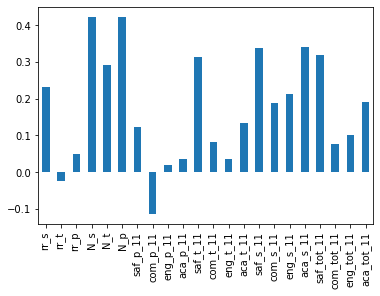

In [25]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
combined.corr()['sat_score'][survey_fields].plot.bar()

#### Exploring Safety
Below is a scatter plot for <code>sat_score</code> and <code>saf_s_11</code> (student saftey score). There is a weak positive correlation between student safety scores and SAT scores. The highest SAT scores fall between safety score of 7 and 8.5. There's no SAT score above ~1500 with safety score below 6.5.

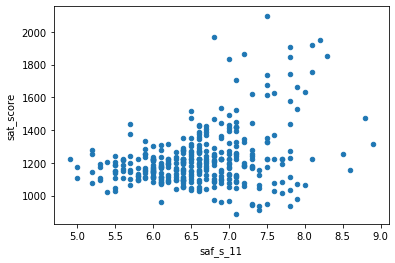

In [26]:
combined.plot.scatter('saf_s_11', 'sat_score')

Below is the average student safety score by borough. We don't see much variability across the different boros - Brooklyn has the lowest 6.37 and Manhattan has the highest 6.83

In [27]:
# average student safety score by boro
boros = combined.groupby('boro').agg(np.mean)['saf_s_11'].sort_values()
boros

boro
Brooklyn         6.370755
Staten Island    6.530000
Bronx            6.606577
Queens           6.721875
Manhattan        6.831370
Name: saf_s_11, dtype: float64

#### Exploring Academic Expectations
The scatter plot for academic expectations and SAT score looks very similar to the one above for safety. It also has a weak positive correlation and there isn't any SAT scores above 1500 with an Academic Expectation score 7.5 or below.

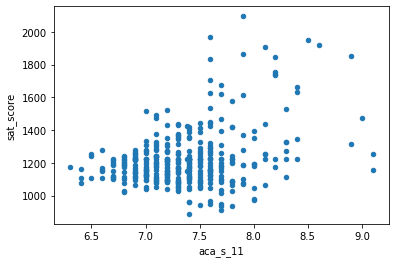

In [28]:
combined.plot.scatter('aca_s_11', 'sat_score')

## SAT Scores and Race
Next we'll explore the relationship between SAT Scores and Race. From the below bar chart, it looks like a higher percentage of white and asian students has a positive correlation with SAT scores. Conversely, a higher percentage of black and hispanic students has a negative correlation. The negative correlation with black and hispanic students seems to be weaker than the positive correlation with white and asian students.

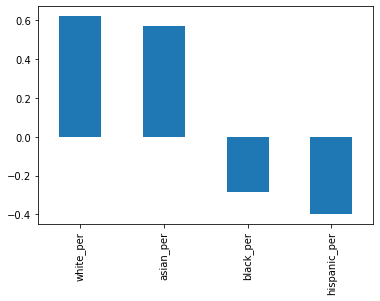

In [29]:
race_col = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][race_col].plot.bar()

### Hispanic & Black Student Percentage
The scatter plots for black student percentage and hispanic student percentage look very similar. Both showing a weak negative correlation.
* For the most part, schools with over 40% hispanic or black students have a SAT score 1400 or lower. In many cases, the average SAT score is 1200 or lower.
* Schools with over 95% hispanic students average less than 1100.

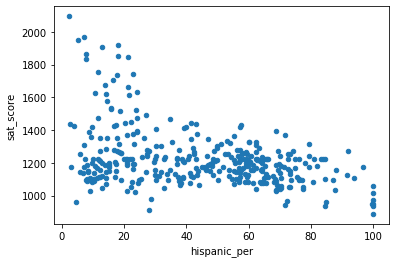

In [30]:
# percentage of hispanic students
combined.plot.scatter('hispanic_per', 'sat_score')

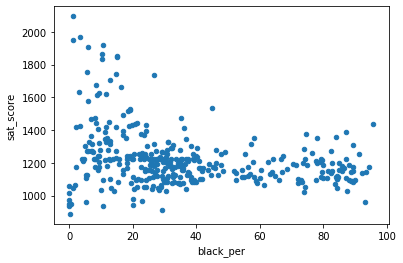

In [31]:
# percentage of black students
combined.plot.scatter('black_per', 'sat_score')

**Schools greater than 95% Hispanic**  
When researching the below schools, they're geared towards immigrants who just recently moved to the United States. Some of these schools are primarily Spanish speaking.

In [32]:
# isolate schools >95% hispanic
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

**Schools less than 10% Hispanic or Black and Greater than 1800 SAT Score**  
When researching the below schools, they're college prepatory and advanced technical/specialized schools.

In [33]:
# isolate schools <10% hispanic and >1800 SAT Score
combined[((combined['hispanic_per'] < 10) | (combined['black_per'] < 10)) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### White & Asian Student Percentage
Below we have scatter plots for SAT scores and the percentage of white and asian students. Both scatter plots look similar with a weak positive correlation. There are only a handful of schools who have more than 50% white or asian students. In both plots, we see a large cluster of schools with 0-10% white or asian students with average SAT scores ranging from below 1000 to 1400.

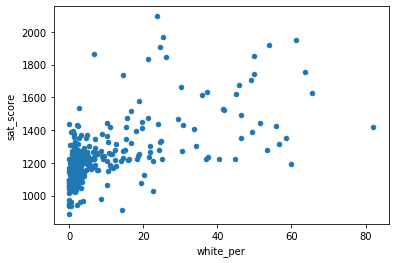

In [34]:
# percentage of white students
combined.plot.scatter('white_per', 'sat_score')

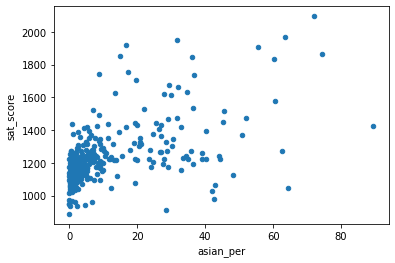

In [35]:
# percentage of asian students
combined.plot.scatter('asian_per', 'sat_score')

**Schools less than 5% White or Asian and less than 1000 SAT Score**   
These schools have very low average SAT scores. We see most of the schools on this list are interantional schools specifically for immigrants who are new to the country.

In [36]:
# isolate schools <5% white or asian and <1000 SAT score 
combined[((combined['asian_per'] < 5) | (combined['white_per'] < 5)) & (combined['sat_score'] < 1000)][['SCHOOL NAME']]

,SCHOOL NAME
91,INTERNATIONAL COMMUNITY HIGH SCHOOL
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY
126,BRONX INTERNATIONAL HIGH SCHOOL
139,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179,HIGH SCHOOL OF WORLD CULTURES
237,IT TAKES A VILLAGE ACADEMY
253,MULTICULTURAL HIGH SCHOOL
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL


## Free and Reduced Lunch Percentage
Below is a scatter plot showing the relationship between SAT scores and the percentage of students who have free and reduced lunch and there is a strong negative correlation. Majority of schools who have 75% or more students with free/reduced lunch have an average SAT score below 1200 with a handful having below 1000.

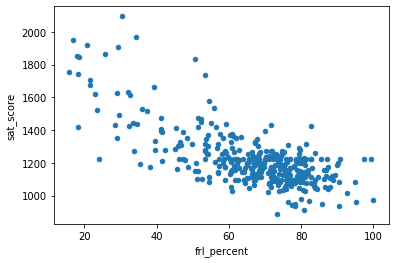

In [37]:
combined.plot.scatter('frl_percent', 'sat_score')

The schools that have more than 75% of sudents who have free lunch and less than 1000 average SAT score seem to be international schools for new immigrants. Similar to what we saw when we were looking at the racial factors above.

In [38]:
combined[(combined['frl_percent'] > 75) & (combined['sat_score'] < 1000)]['SCHOOL NAME']

91                  INTERNATIONAL COMMUNITY HIGH SCHOOL
125                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                     BRONX INTERNATIONAL HIGH SCHOOL
139               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                       HIGH SCHOOL OF WORLD CULTURES
188                  BROOKLYN INTERNATIONAL HIGH SCHOOL
225       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
237                          IT TAKES A VILLAGE ACADEMY
286              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## SAT Scores and Gender
Below we'll take a look at the relationship between SAT scores and gender. The bar chart and scatter plot both demonstrate a very weak correlation. For males there's a weak negative correlation (-.10) and for females there is a weak positive correlation (.10).

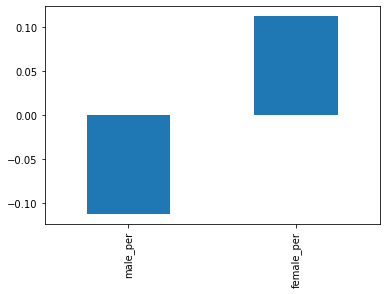

In [39]:
gender_col = ['male_per', 'female_per']

combined.corr()['sat_score'][gender_col].plot.bar()

**Percentage of Female Students**  
The scatter plot below confirms there is little to no correlation between percentage of female students and SAT scores. The highest SAT scores come from student populations that are 40 and 80 percent female.

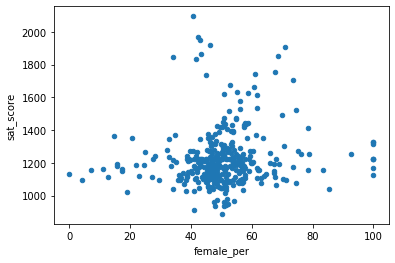

In [40]:
# percentage of female students
combined.plot.scatter('female_per', 'sat_score')

Below we isolated schools that have over 60% female students and average SAT scores above 1600. Researching these schools, they are mainly college prepatory school and screen students coming in based on academic requirements.

In [41]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1600)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
287                    BARD HIGH SCHOOL EARLY COLLEGE II
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

**Percentage of Male Students**  
The highest SAT scores are between 20-60% male students. Besides one outlier, schools with over 60% male students have average sat scores below 1400.

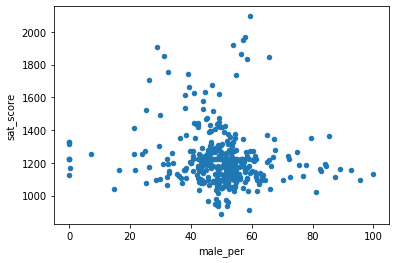

In [42]:
# percentage of male students
combined.plot.scatter('male_per', 'sat_score')

The below schools (greater than 40% male students and greater than 1600 average SAT score) are all elite and majority are specialized in science or technology. 

In [43]:
combined[(combined['male_per'] > 50) & (combined['sat_score'] > 1600)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## SAT Scores and AP Courses
Lastly, we'll look at different metrics related to AP courses and compare those with SAT scores. The first relationship we examine is between percentage of students who've taken an AP test and SAT scores. We want to calculate the percentage of students who've taken an AP test vs total number of students who've taken an AP test because very large or small schools could be swaying the numbers.

In [44]:
# calculate percentage of students who've taken an AP test
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

There is a weak correlation between percentage of students who've taken an AP test and SAT scores. The highest SAT scores come from schools with 20-40% of AP students. Schools with over 60% of AP students have an average SAT score of 1200 or below.

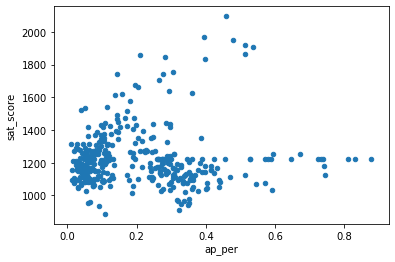

In [45]:
combined.plot.scatter('ap_per', 'sat_score')

Next we look at the relationship between the number of advanced placement courses a school offers and SAT scores. First we'll create a new column to count the number of AP courses.

In [46]:
combined['advancedplacement_courses'].head()

0                                           Psychology
1    Calculus AB, Chinese Language and Culture, Eng...
2      Calculus AB, English Literature and Composition
3    English Literature and Composition, Studio Art...
4    Biology, Calculus AB, Calculus BC, Chemistry, ...
Name: advancedplacement_courses, dtype: object

In [47]:
# new column to count how many adv courses are available
combined['num_adv_courses'] = combined['advancedplacement_courses'].str.split(',').str.len()

We do see a moderate positive correlatin between the number of AP courses a school has and SAT scores At the lowest end (schools with 1 AP course) we see some of the lowest SAT scores of 1200 and below and at the highest end (schools with >25 AP courses) we see the highest SAT scores of around 1800-2200. Inbetween those we see a lot of variability though. 

In [48]:
combined.corr()['sat_score']['num_adv_courses']

0.5990080969759137

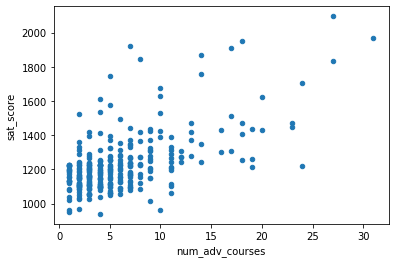

In [49]:
combined.plot.scatter('num_adv_courses', 'sat_score')

# Conclusion

In this project we looked at how different factors affected high school student's SAT Scores. We looked at the realtionship between SAT scores and school safety, race, gender, economic factors, and AP course opportunities. To summarize some of our findings: 
* Lower school safety scores from students have lower SAT scores and vice versa
* When students perceive lower academic expectations, SAT scores tend to be lower and vice versa
* Schools with higher pecentage of white or asian students have higher SAT scores then schools with higher percentage of black and hispanic students
* A higher percentage of students who get free or reduced lunch results in lower SAT scores
* Percentage of Female or Male students has almost no relationship with SAT scores
* AP course availability has a slight positive correlation with SAT scores

This is a complicated topic as there are so many factors to consider and we didn't necessarily see an extremely strong correlations between SAT scores and any of the factors to make any definitive claims. However, there were multiple examples where we saw International schools, geared towards immigrants who are new to the country, with lowest SAT scores. I can't help but attribute that to language barriers, at least in part. Perhaps the strongest correlation we saw was between SAT scores and percentage of students who have free or reduced lunch. This points to schools in lower income areas performing worse. These schools tend to also have a larger population of miniortiy groups. On the other end of the spectrum, we saw the opposite. Schools who have a higher percentage of white or asian kids and top SAT scores tended to also be elite or specialized schools. 

The results of this project make me question the weight the SAT can have on a kid's future. With so many factors at play, I don't know if so much emphasis should be put on a standardized test like the SAT. If the goal is to measure a high schooler's potential at the next level, I think there are better ways to do that. 